<a href="https://colab.research.google.com/github/anu-007/make_more_hashtags/blob/main/wavenet/make_more_tags_wavenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [74]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [75]:
!wget 'https://raw.githubusercontent.com/anu-007/make_more_hashtags/refs/heads/main/tags.json'

--2025-09-01 10:24:52--  https://raw.githubusercontent.com/anu-007/make_more_hashtags/refs/heads/main/tags.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 36129 (35K) [text/plain]
Saving to: ‘tags.json.1’

tags.json.1         100%[===================>]  35.28K  --.-KB/s    in 0.01s   

2025-09-01 10:24:53 (3.37 MB/s) - ‘tags.json.1’ saved [36129/36129]



In [76]:
import json

tags = []
with open('tags.json', 'r') as file:
  data = json.load(file)
  for d in data:
    tags.append(d[0])
tags[:5]

['hiring', 'engineeringjobs', 'hardware', 'hiring', 'nowhiring']

In [77]:
vocab = sorted(list(set(''.join(tags))))

stoi = {s:i+1 for i,s in enumerate(vocab)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}

In [78]:
import random
random.seed(42)
random.shuffle(tags)

In [98]:
block_size = 8

def build_dataset(tags):
  X, Y = [], []

  for t in tags:
    context = [0]*block_size
    for ch in t + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  return X, Y

n1 = int(0.8*len(tags))
n2 = int(0.9*len(tags))
Xtr, Ytr = build_dataset(tags[:n1])
Xdev, Ydev = build_dataset(tags[n1:n2])
Xte, Yte = build_dataset(tags[n2:])

In [80]:
for x, y in zip(Xtr[:20], Ytr[:20]):
  print(''.join(itos[ix.item()]for ix in x), '--->', itos[y.item()])

........ ---> a
.......a ---> n
......an ---> a
.....ana ---> l
....anal ---> y
...analy ---> t
..analyt ---> i
.analyti ---> c
analytic ---> s
nalytics ---> .
........ ---> s
.......s ---> e
......se ---> l
.....sel ---> f
....self ---> l
...selfl ---> o
..selflo ---> v
.selflov ---> e
selflove ---> .
........ ---> P


In [99]:
class Linear:
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in*0.5
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)

    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0, 1)
      xmean = x.mean(dim, keepdim=True)
      xvar = x.var(dim, keepdim=True)
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
    self.out = self.gamma * xhat + self.beta

    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar

    return self.out

  def parameters(self):
    return [self.gamma, self.beta]


class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out

  def parameters(self):
    return []

class Embedding:
  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))

  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out

  def parameters(self):
    return [self.weight]

class FlattenConsecutive:
  def __init__(self, n):
    self.n = n

  def __call__(self, x):
    B, T, C = x.shape
    x = x.view(B, T//self.n, C*self.n)
    if x.shape[1] == 1:
      x = x.squeeze(1)
    self.out = x
    return self.out

  def parameters(self):
    return []

class Sequential:
  def __init__(self, layers):
    self.layers = layers

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [82]:
torch.manual_seed(42)

In [100]:
vocab_len = max(stoi.values()) + 1
n_embed = 5
n_hidden = 69

model = Sequential([
    Embedding(vocab_len, n_embed),
    FlattenConsecutive(2), Linear(n_embed*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_len)
])

with torch.no_grad():
  layers[-1].weight *= 0.1

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True

23973


In [101]:
max_step = 30000
batch_size = 32
lossi = []

for i in range(max_step):
  #minibatch
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb = Xtr[ix]
  Yb = Ytr[ix]

  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.001 if i < 15000 else 0.0001
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 1000 == 0:
    print(f'{i:7d}/{max_step:7d} : {loss.item():4f}')
  lossi.append(loss.log10().item())

      0/  30000 : 3.935018
   1000/  30000 : 3.580650
   2000/  30000 : 3.406801
   3000/  30000 : 3.194032
   4000/  30000 : 2.822662
   5000/  30000 : 2.870268
   6000/  30000 : 2.782472
   7000/  30000 : 3.198720
   8000/  30000 : 2.149829
   9000/  30000 : 2.509790
  10000/  30000 : 2.178983
  11000/  30000 : 1.951573
  12000/  30000 : 2.027407
  13000/  30000 : 1.884646
  14000/  30000 : 2.680944
  15000/  30000 : 1.464303
  16000/  30000 : 1.998484
  17000/  30000 : 1.940620
  18000/  30000 : 1.885246
  19000/  30000 : 1.413008
  20000/  30000 : 1.612215
  21000/  30000 : 1.643467
  22000/  30000 : 1.786240
  23000/  30000 : 1.548077
  24000/  30000 : 1.253859
  25000/  30000 : 1.676139
  26000/  30000 : 1.843355
  27000/  30000 : 1.774904
  28000/  30000 : 1.348477
  29000/  30000 : 1.630881


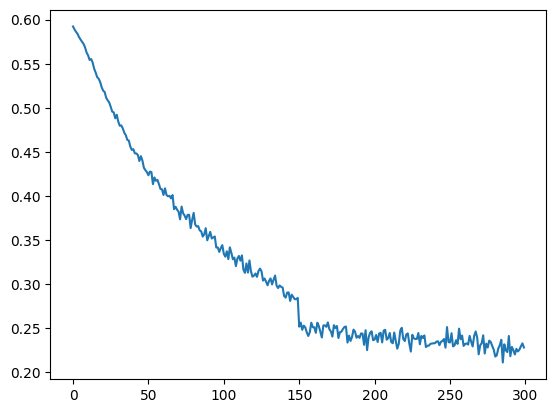

In [102]:
plt.plot(torch.tensor(lossi).view(-1, 100).mean(1))

In [103]:
for layer in model.layers:
  layer.training = False

In [104]:
@torch.no_grad()
def split_loss(split):
  x, y = {
    'train': (Xtr, Ytr),
    'dev': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('dev')

train 1.6104060411453247
dev 2.31227970123291


In [105]:
#sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
  out = []
  context = [0] * block_size
  while True:
    logits = model(torch.tensor([context]))
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break
  print(''.join(itos[i] for i in out))

BvhiAzkPipUftrreales.
fucFicowrience.
lL5ortuAg.
LosiGlEtoatekaJgiudBatacpis.
luliJ.
yucraAnarsatze.
BICjras.
cestaCi.
brony.
utaldcConrunsentWoclience.
MomVFteshcencWVstrevecri5W.
Ccure.
fitness.
retiebftiutonitEranMSeeLs.
muviHDlltipSneSOCiferroncentUonLu.
Dwuiti.
mevpeleerp.
actxenlisicVenlAwabeotLisDtOilisic.
mentalOolics.
bricC.
